# Uso de Deep Learning para Séries Temporais (LSTMs)

**Disciplina**: Sistemas Inteligentes 2

Graduação em Engenharia de Computação - Universidade Tecnologica Federal do Paraná

**Aula 09**: RNNs e LSTMs

**Exemplo 01**: Executando Redes Recorrentes em Séries Temporais
---

In [ ]:
# importando as bibliotecas necessárias para rodar o script

# manipulação de números de ponto flutuante
import numpy as np

# manipulação de redes neurais (keras)
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten, Dense, LSTM, SimpleRNN
from keras.models import Sequential
from keras.losses import mean_squared_error

# plotagem de gráficos via matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',  labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 1 - Gerar datasets e plots de séries temporais artificiais

In [ ]:
# -------------------------------------------------------------------------------
# Cria uma série temporal univariada. A função cria quantas séries pedirmos,
# com base no parâmetro ``batch_size``. Cada série tem tamanho = n_steps
# -------------------------------------------------------------------------------
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series =  0.5 * np.sin((time - offset1) * (freq1 * 10 + 10)) # onda 1
  series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20)) # onda 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + ruído
  return (series[...,np.newaxis].astype(np.float32))

In [ ]:
# seed para reprodutibilidade
keras.utils.set_random_seed(42)

# gerar 10k séries de tamanho = 51
n_steps = 50
series = generate_time_series(batch_size = 10000, n_steps=(n_steps+1))

In [ ]:
# dividir os dados em treino/validação/teste
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test   = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
# Verificando o formato dos dados
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

### **Plotando Séries Temporais**

Função para realizar o plot de uma série temporal, e podermos ver como são os sinais gerados pela nossa função geradora de dados artificiais

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

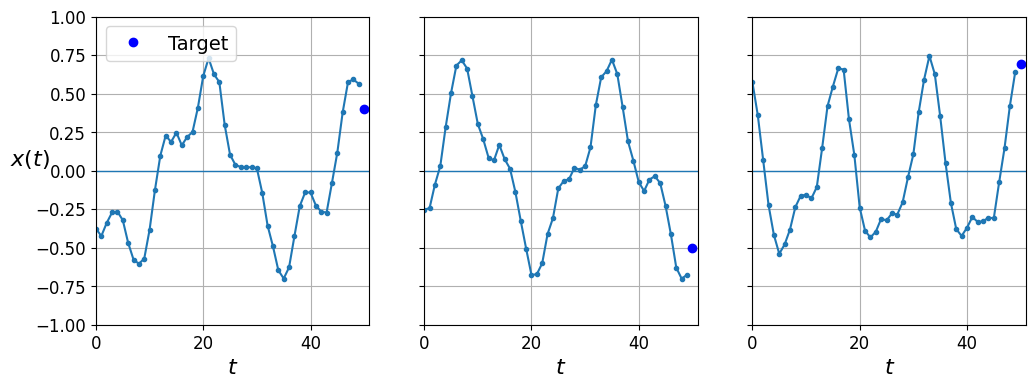

In [ ]:
# Visualizando algumas das séries que foram geradas pela nossa função
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [ ]:
# função para plotar as curvas dos erros de treinamento e validação
def plot_learning_curves(loss, val_loss, max_y=0.2):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, max_y])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# 2 - Gerando alguns Baselines Simples


---
## 2.1) predições Naive: prediz/repete apenas o último valor observado
---

In [ ]:
naive_y_pred = X_valid[:, -1]
naiveForecasting = np.mean(mean_squared_error(y_valid, naive_y_pred))
print(naiveForecasting)

0.020211367


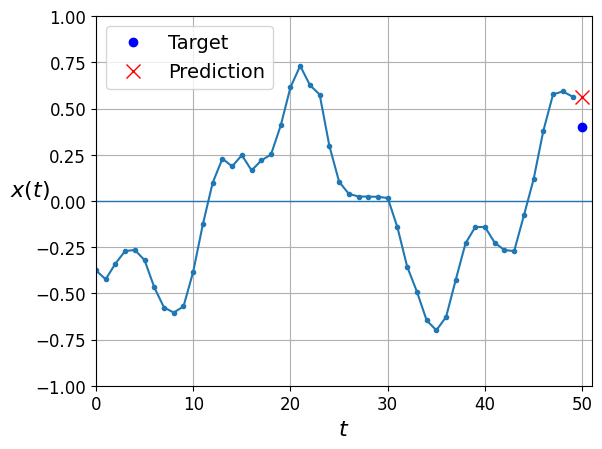

In [ ]:
# Visualizando a primeira série temporal e valor predito pelo modelo Nayve
plot_series(X_valid[0, :, 0], y_valid[0, 0], naive_y_pred[0, 0])
plt.show()

---
## 2.2) Baseline linear
---


In [ ]:
# seed para reprodutibilidade
keras.utils.set_random_seed(42)

# definindo um modelo linear
linearModel = Sequential([
        Flatten(input_shape = [50,1]),
        Dense(1)
])
linearModel.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 50)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Treinando o modelo linear
linearModel.compile(optimizer = "adam", loss = "mse")
linearHistory = linearModel.fit(
    x = X_train,
    y = y_train,
    epochs = 20,
    validation_data = (X_valid, y_valid)
)

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0977 - val_loss: 0.0440
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0303 - val_loss: 0.0199
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0119
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0052

In [ ]:
# Avaliando o modelo linear no conjunto de validação
linearError = linearModel.evaluate(X_valid, y_valid)
linearError

63/63 [==============================] - 0s 1ms/step - loss: 0.0038


0.0038320417515933514

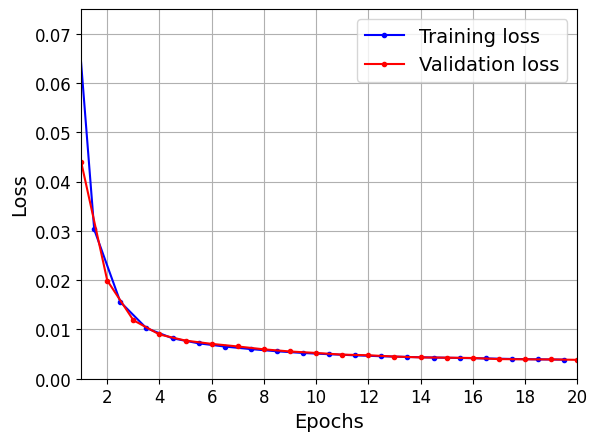

In [ ]:
# Visualizando as curvas de aprendizado do modelo linear
plot_learning_curves(linearHistory.history["loss"], linearHistory.history["val_loss"], max_y = 0.075)
plt.show()

63/63 [==============================] - 0s 2ms/step


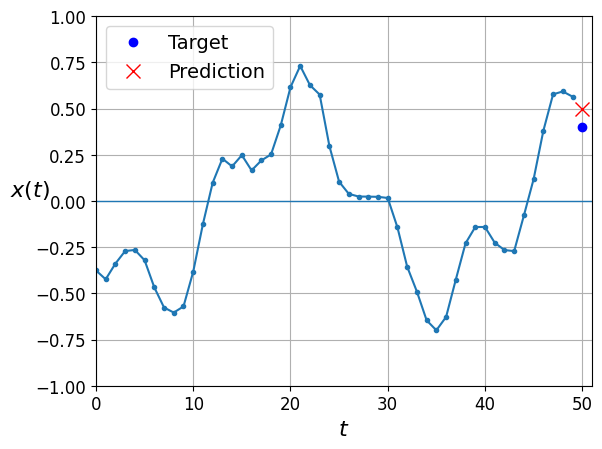

In [ ]:
# Computando a proxima predição e visualizando no gráfico da série
linear_y_pred = linearModel.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], linear_y_pred[0, 0])
plt.show()

# 3 - Gerando Redes Recorrentes

---
## 3.1 - Rede recorrente simples
---

In [ ]:
# seed para reprodutibilidade
keras.utils.set_random_seed(42)

# modelo simples de RNN
simpleRNNModel = Sequential([
    SimpleRNN(1, input_shape=[None, 1])
])

# treinando a rede
optimizer = keras.optimizers.Adam(learning_rate=0.005)
simpleRNNModel.compile(loss="mse", optimizer=optimizer)
simpleRRNhistory = simpleRNNModel.fit(
    x = X_train,
    y = y_train,
    epochs = 20,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 0.1115 - val_loss: 0.0390
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0316 - val_loss: 0.0263
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0231 - val_loss: 0.0201
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0185 - val_loss: 0.0166
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0157 - val_loss: 0.0144
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0140 - val_loss: 0.0129
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0115 - val_loss: 0.

In [ ]:
# avaliar o modelo simples de RNN
simpleRNNError = simpleRNNModel.evaluate(X_valid, y_valid)
simpleRNNError

63/63 [==============================] - 0s 7ms/step - loss: 0.0109


0.01088420394808054

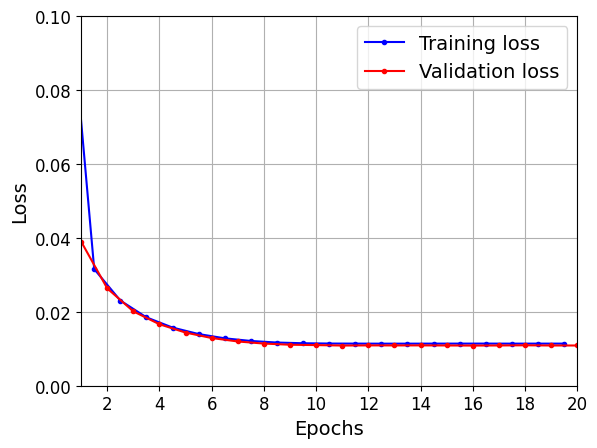

In [ ]:
# visualizando os erros
plot_learning_curves(simpleRRNhistory.history["loss"], simpleRRNhistory.history["val_loss"], max_y = 0.1)
plt.show()

63/63 [==============================] - 1s 6ms/step


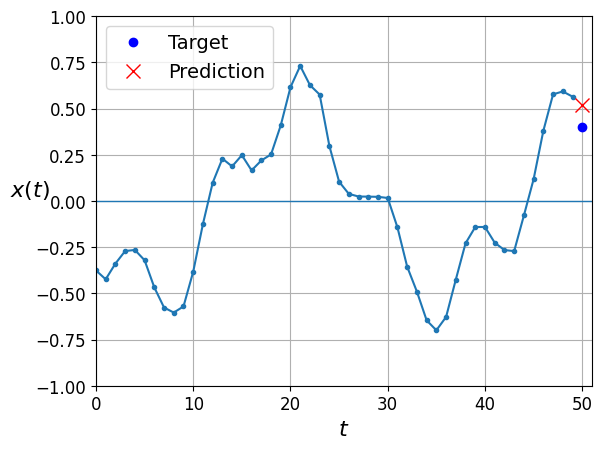

In [ ]:
# Computando a proxima predição e visualizando no gráfico da série
simple_y_pred = simpleRNNModel.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], simple_y_pred[0, 0])

plt.show()

---
## 3.2 - Deep RNNs
---

In [ ]:
# seed para reprodutibilidade
keras.utils.set_random_seed(42)

# modelo simples de RNN
deepRNNmodel = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(1)
])

# treinando a rede
deepRNNmodel.compile(loss="mse", optimizer="adam")
deepRNNhistory = deepRNNmodel.fit(
    x = X_train,
    y = y_train,
    epochs = 20,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
219/219 [==============================] - 61s 30ms/step - loss: 0.0621 - val_loss: 0.0059
Epoch 2/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 4/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 6/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0032 - val

In [ ]:
# avaliando o modelo em termos de MSE
deepRNNError = deepRNNmodel.evaluate(X_valid, y_valid)
deepRNNError

63/63 [==============================] - 1s 18ms/step - loss: 0.0028


0.0028485299553722143

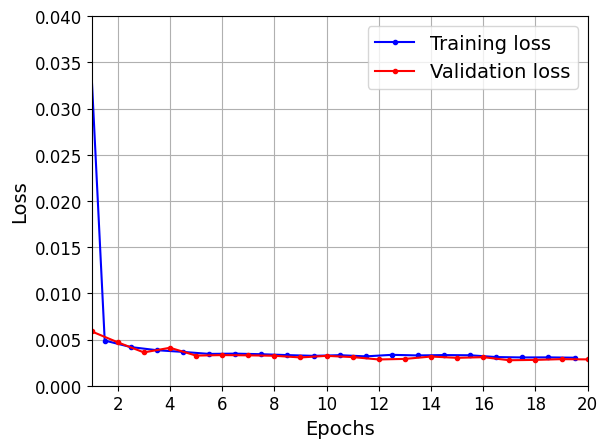

In [ ]:
# Visualizando as curvas de aprendizado do deep RNN
plot_learning_curves(deepRNNhistory.history["loss"], deepRNNhistory.history["val_loss"], max_y = 0.04)
plt.show()

63/63 [==============================] - 1s 8ms/step


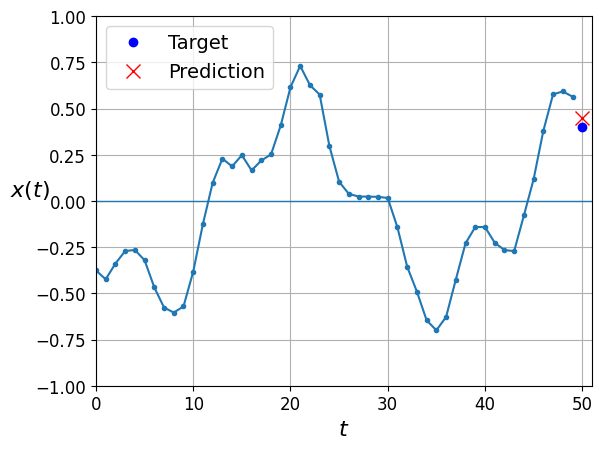

In [ ]:
# Visualizando a predição
deepRNN_y_pred = deepRNNmodel.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], deepRNN_y_pred[0, 0])
plt.show()

---
## 3.3 - Segunda RNN simples
---

Aapenas a segunda camada (oculta) retorna o valor na retroalimentação:

In [ ]:
# seed para reprodutibilidade
keras.utils.set_random_seed(42)

# modelo simples de RNN
deepRNNmodel2 = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), # essa camada retroalimenta a rede
    SimpleRNN(20),                                               # essa camada não
    Dense(1)
])

# treinando a rede
deepRNNmodel2.compile(loss="mse", optimizer="adam")
deepRNNmodelhistory2 = deepRNNmodel2.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.0216 - val_loss: 0.0040
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0029 - val_lo

In [ ]:
deepRNN2Error = deepRNNmodel2.evaluate(X_valid, y_valid)
deepRNN2Error

63/63 [==============================] - 1s 13ms/step - loss: 0.0025


0.0025378288701176643

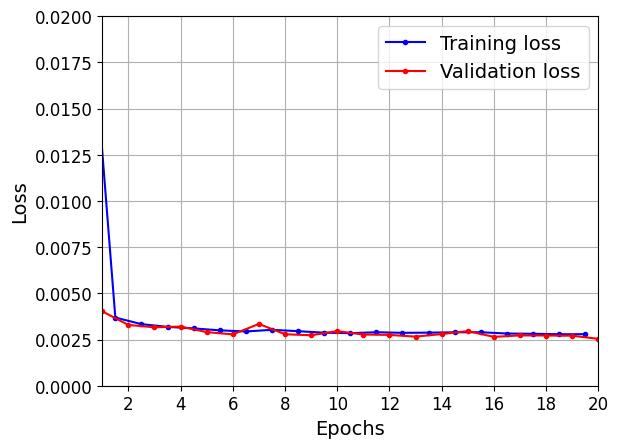

In [ ]:
plot_learning_curves(deepRNNmodelhistory2.history["loss"], deepRNNmodelhistory2.history["val_loss"], max_y = 0.02)
plt.show()

63/63 [==============================] - 0s 6ms/step


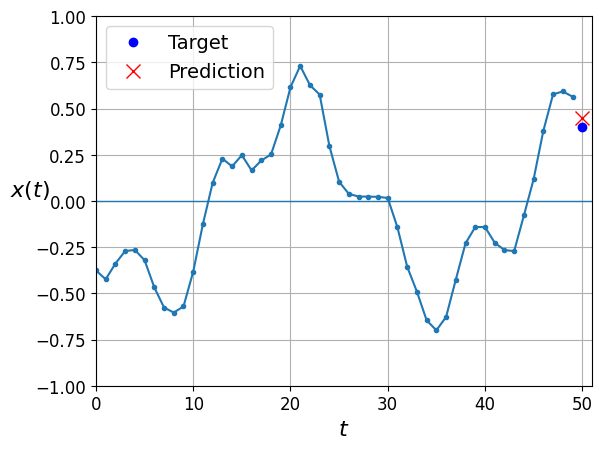

In [ ]:
deepRNN2_y_pred = deepRNNmodel2.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], deepRNN2_y_pred[0, 0])
plt.show()

---
## 3.4 - LSTM
---

In [ ]:
# seed para reprodutibilidade
keras.utils.set_random_seed(42)

# modelo LSTM
lstmModel = Sequential([
    LSTM(50, return_sequences=True, input_shape=[None, 1]),
    Dense(1)
])

# treinando a rede
lstmModel.compile(loss="mse", optimizer="adam")
lstmHistory = lstmModel.fit(
    x = X_train,
    y = y_train,
    epochs = 20,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
219/219 [==============================] - 9s 27ms/step - loss: 0.1443 - val_loss: 0.1498
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.1436 - val_loss: 0.1497
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.1435 - val_loss: 0.1491
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.1421 - val_loss: 0.1469
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.1409 - val_loss: 0.1438
Epoch 6/20
219/219 [==============================] - 6s 25ms/step - loss: 0.1213 - val_loss: 0.1082
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.1042 - val_loss: 0.0969
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0947 - val_loss: 0.0969
Epoch 9/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0888 - val_loss: 0.0882
Epoch 10/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0871 - val_lo

In [ ]:
lstmError = lstmModel.evaluate(X_valid, y_valid)
lstmError

63/63 [==============================] - 1s 8ms/step - loss: 0.0737


0.0737

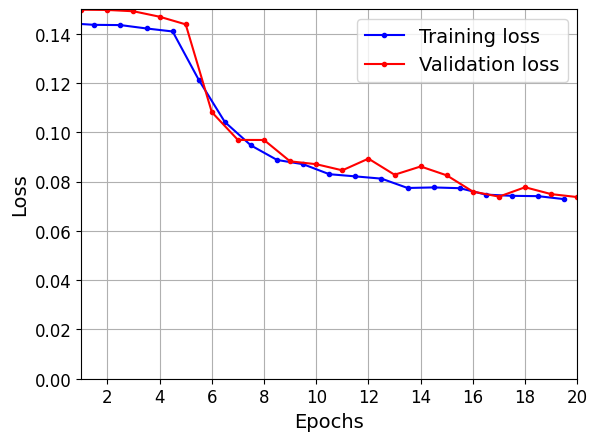

In [ ]:
plot_learning_curves(lstmHistory.history["loss"], lstmHistory.history["val_loss"], max_y = 0.15)
plt.show()

63/63 [==============================] - 1s 11ms/step


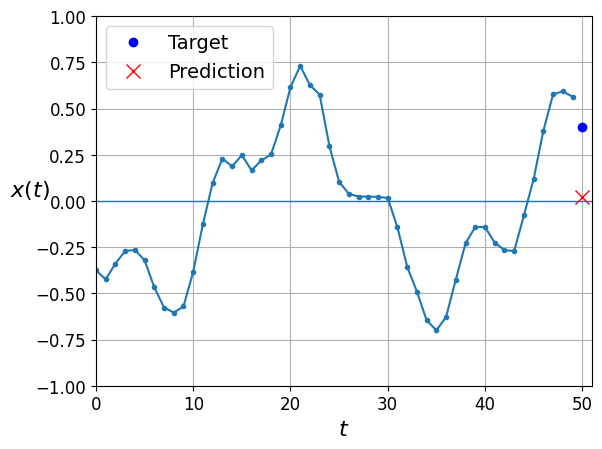

In [ ]:
lstm_y_pred = lstmModel.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], lstm_y_pred[0, 0])
plt.show()

In [ ]:
lstm_y_pred[0][0][0]

0.023597574

---
## 3.5 - LSTM com mais unidades e camadas
---

In [ ]:
# seed para reprodutibilidade
keras.utils.set_random_seed(42)

deepLstmModel = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=[None, 1]),
    LSTM(50, activation='relu'),
    Dense(1)
])

deepLstmModel.compile(loss="mse", optimizer="adam")
deepLstmHistory = deepLstmModel.fit(
    x = X_train,
    y = y_train,
    epochs = 20,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
219/219 [==============================] - 15s 51ms/step - loss: 0.0542 - val_loss: 0.0352
Epoch 2/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0293 - val_loss: 0.0185
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0095 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 5/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 8/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 12s 53ms/step - loss: 0.003

In [ ]:
deepLstmError = deepLstmModel.evaluate(X_valid, y_valid)
deepLstmError

63/63 [==============================] - 1s 14ms/step - loss: 0.0026


0.0026329096872359514

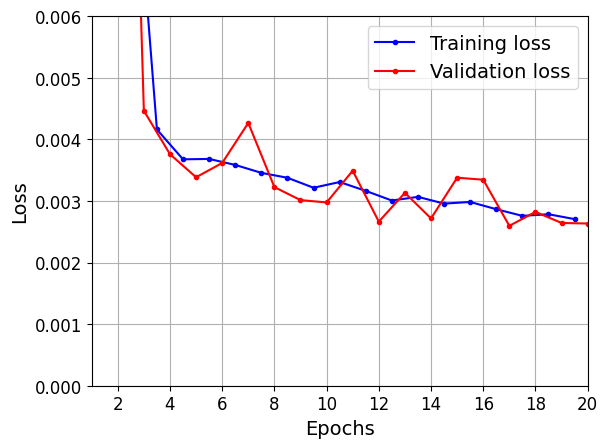

In [ ]:
plot_learning_curves(deepLstmHistory.history["loss"], deepLstmHistory.history["val_loss"], max_y = 0.006)
plt.show()

63/63 [==============================] - 1s 20ms/step


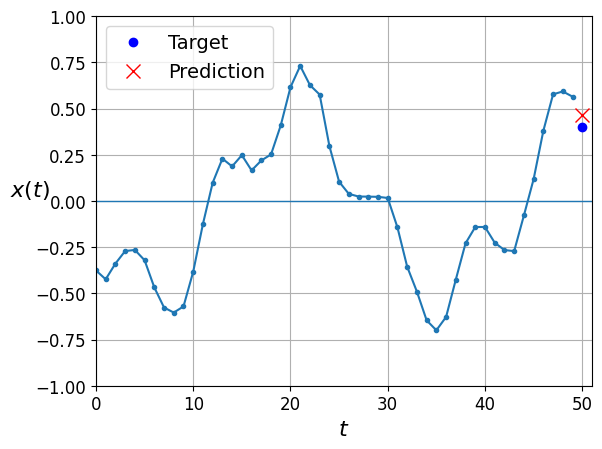

In [ ]:
deepLSTM_y_pred = deepLstmModel.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], deepLSTM_y_pred[0, 0])
plt.show()

---
# 4 - Comparar predições
---

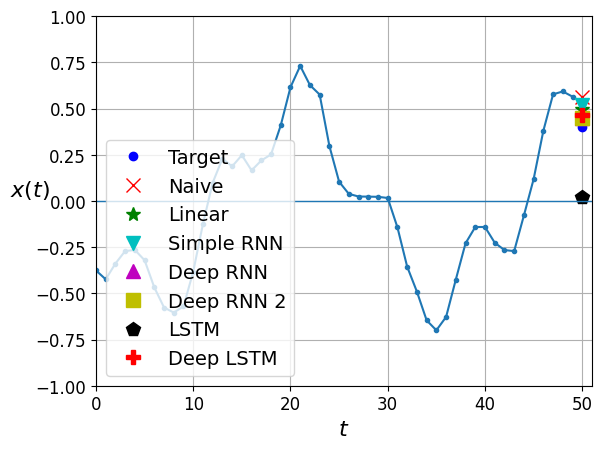

In [ ]:
# def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
plt.plot(X_valid[0, :, 0], ".-")
plt.plot(n_steps, y_valid[0, 0], "bo", label="Target")
plt.plot(n_steps, naive_y_pred[0, 0], "rx", markersize=10, label="Naive")
plt.plot(n_steps, linear_y_pred[0, 0], "g*", markersize=10, label="Linear")
plt.plot(n_steps, simple_y_pred[0, 0], "cv", markersize=10, label="Simple RNN")
plt.plot(n_steps, deepRNN_y_pred[0, 0], "m^", markersize=10, label="Deep RNN")
plt.plot(n_steps, deepRNN2_y_pred[0, 0], "ys", markersize=10, label="Deep RNN 2")
plt.plot(n_steps, lstm_y_pred[0][0][0], "kp", markersize=10, label="LSTM")
plt.plot(n_steps, deepLSTM_y_pred[0, 0], "rP", markersize=10, label="Deep LSTM")

plt.grid(True)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$x(t)$", fontsize=16, rotation=0)
plt.hlines(0, 0, 100, linewidth=1)
plt.axis([0, n_steps + 1, -1, 1])
plt.legend(fontsize=14, loc=3)

In [ ]:
import pandas as pd

predictions = pd.DataFrame([naive_y_pred[0, 0], linear_y_pred[0, 0], simple_y_pred[0, 0],
               deepRNN_y_pred[0, 0], deepRNN2_y_pred[0, 0], lstm_y_pred[0][0][0], deepLSTM_y_pred[0, 0]])

errors = pd.DataFrame([
    naiveForecasting, #naive
    linearError,
    simpleRNNError,
    deepRNNError,
    deepRNN2Error,
    lstmError,
    deepLstmError
])

methods = pd.DataFrame(["Naive", "Linear", "Simple RNN", "Deep RNN", "Deep RNN 2", "LSTM", "Deep LSTM"])

In [ ]:
df = pd.concat([predictions, errors, methods], axis = 1)
df.columns = ['Prediction', 'Error', 'Methods']
df

,Prediction,Error,Methods
0,0.564307,0.020211,Naive
1,0.499824,0.003832,Linear
2,0.517073,0.010884,Simple RNN
3,0.451045,0.002849,Deep RNN
4,0.448751,0.002538,Deep RNN 2
5,0.023598,0.073700,LSTM
6,0.467540,0.002633,Deep LSTM


In [ ]:
df['Prediction'] = df['Prediction'].round(decimals=3)
df['Error'] = df['Error'].round(decimals=3)
df

,Prediction,Error,Methods
0,0.564,0.020,Naive
1,0.500,0.004,Linear
2,0.517,0.011,Simple RNN
3,0.451,0.003,Deep RNN
4,0.449,0.003,Deep RNN 2
5,0.024,0.074,LSTM
6,0.468,0.003,Deep LSTM
